<img src="../../strathclyde_banner.png" alt="University of Strathclyde" width="50%">

# 1. Automatic Modulation Classification

## Introduction

Historically the field of Automatic Modulation Classification (AMC) has primarily been an interest in the defence sector for signal intelligence. For example it is important to know if a transmission is friendly to know whether it is a good idea to jam it. However, with new generation wireless networks that are becoming more intelligent, we are seeing a huge increase in research for civilian applications. AMC will often be applied for cognitive radio tasks, such as monitoring channel occupancy, to better coordinate allocation, improve quality of service to users and make more efficient use of the radio frequency spectrum. 

In this notebook we will cover some basics concepts of AMC, including how to manually create a decision tree classifier using statistical features, such as higher order moments, evaluate it under an snr range and get more insight into our misclassifications by plotting a confusion matrix. The next notebook will show how we can leverage machine learning to learn classification based on our calculated features, so we do not have to manually type out rules for a decision tree classifier.

## Table of Contents

* [1.1 Modulated Data Generation](#data)
* [1.2 Statistics-based Classification](#stats)
* [1.3 Decision Tree Classifier](#dt)
* [1.4 Confusion Matrix](#confusion)
* [1.5 Conclusion](#conclusion)
    
Throughout this notebook we will only be using Numpy and Matplotlib, for computation and visualization respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1.1 Modulated Data Generation <a class="anchor" id="data"></a>

First we will define some functions to ease the generation of modulated data we will be working with throughout this notebook. We will be making simple models that are able of classifying Binary Phase Shift Keying (BPSK), (Quadrature Phase Shift Keying) QPSK, Quadrature Amplitude Modulation (QAM) and  Amplitude Shift Keying (ASK).

We will also be adding some additive white gaussian noise (AWGN) to all our waveforms, the reason for this is two-fold - we will want to test the robustness of our classifiers and when computing statistics, adding a bit of noise can avoid some division by zero warnings when computing higher order moments.

In [2]:
# Function to add white gaussian noise to a signal, specify SNR in dB
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return signal + complex_noise

# Function to generate BPSK
def generate_bpsk(num_symbols, noise=50):
    bits = np.random.randint(0,2,num_symbols)
    bpsk_scheme = [1+0j, -1+0j]
    bpsk_symbols = np.array([bpsk_scheme[i] for i in bits])
    
    bpsk_symbols = awgn(bpsk_symbols, noise)
    
    return bpsk_symbols

# Function to generate QPSK
def generate_qpsk(num_symbols, noise=50):
    qpsk_scheme= [1+1j, 1-1j, -1+1j, -1-1j]
    ints = np.random.randint(0,4,num_symbols)
    qpsk_symbols = np.array([qpsk_scheme[i] for i in ints])/np.sqrt(2)

    qpsk_symbols = awgn(qpsk_symbols, noise)
    
    return qpsk_symbols

# Function to generate QAM
def generate_qam(num_symbols, noise=50):
    qam_scheme = [-3-3j, -3-1j, -3+3j, -3+1j,  \
                  -1-3j, -1-1j, -1+3j, -1+1j,  \
                   3-3j,  3-1j,  3+3j,  3+1j,  \
                   1-3j,  1-1j,  1+3j,  1+1j]
    ints = np.random.randint(0,16,num_symbols)
    qam_symbols = np.array([qam_scheme[i] for i in ints])
    qam_symbols = qam_symbols/np.mean(np.abs(qam_scheme))
    
    qam_symbols = awgn(qam_symbols, noise)
    
    return qam_symbols

# Function to generate 4-ASK
def generate_ask4(num_symbols, noise=50):
    ask4_scheme = [3+0j, 1+0j, -1+0j, -3+0j]
    ints = np.random.randint(0,4,num_symbols)
    ask4_symbols = np.array([ask4_scheme[i] for i in ints])
    ask4_symbols = ask4_symbols/np.mean(np.abs(ask4_scheme))
    
    ask4_symbols = awgn(ask4_symbols, noise)
    
    return ask4_symbols

Let us look at the signals we are dealing with

Text(0.5, 1.0, '4-ASK')

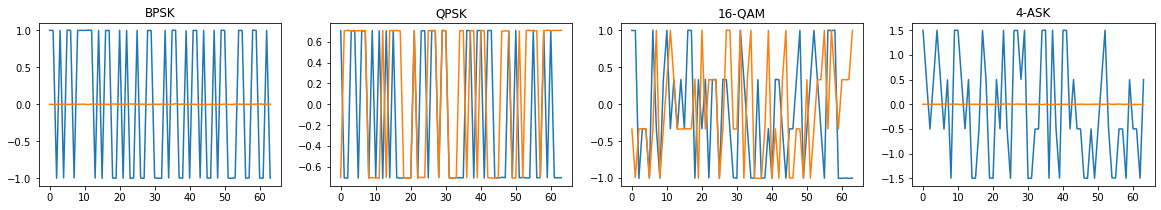

In [3]:
bpsk_symbols = generate_bpsk(64)
qpsk_symbols = generate_qpsk(64)
qam_symbols = generate_qam(64)
ask4_symbols = generate_ask4(64)

fig, ax = plt.subplots(1,4, figsize=(20,3))

ax[0].plot(bpsk_symbols.real)
ax[0].plot(bpsk_symbols.imag)
ax[0].set_title('BPSK')

ax[1].plot(qpsk_symbols.real)
ax[1].plot(qpsk_symbols.imag)
ax[1].set_title('QPSK')

ax[2].plot(qam_symbols.real)
ax[2].plot(qam_symbols.imag)
ax[2].set_title('16-QAM')

ax[3].plot(ask4_symbols.real)
ax[3].plot(ask4_symbols.imag)
ax[3].set_title('4-ASK')

## 1.2 Statistics-Based Classification <a class="anchor" id="stats"></a>

A common method of classification, without machine learning, has historically been analytical - exploring the statistics of signals and manually determining classification rules based on that analysis. One way of doing this is by extracting the instantaneous amplitude $A(t)$ and instantaneous phase $\theta(t)$, of a time domain signal $x(t)$, which is made up of real and imaginary components. In Numpy we can do this by using np.abs and np.angle functions.

Once we extract these instantaneous values, we can compute various statistics on them. 

**Higher Order Moments**

The definition of $n^{th}$ order moment is given by

$\mu_{n} = E[(x-E[x])^{n}]$

Here E[x] is our expected value (or more practically the mean) of a random variable x, and $n$ is the order of our moment. The first and 2nd order moments you may be familiar with as they have names - the mean and variance. Once we go above the 2nd order moment we will more commonly see the standardized moments used, defined as

$\tilde{\mu_{n}} = \frac{E[(x-E[x])^{n}]}{(E[(x-E[x])^{2}])^{n/2}}$

The normalization here is a division by the standard deviation, making these moments scale invariant - which is a useful property in machine learning classification at the very least as we normally want to somehow normalize our inputs anyway. The 3rd and 4th order standardized moments are called *skewness* and *kurtosis*, respectively, and are heavily used in statistics.

For our examples we will be computing the variance, skewness and kurtosis of the instantaneous amplitude and phase values for our signals. Note that we may not use all of them right now, but will take advantage later sections of the notebook.

In [4]:
def calculate_statistics(x):
    
    # Extract instantaneous amplitude and phase
    inst_a = np.abs(x) 
    inst_p = np.angle(x)

    # Amplitude statistics
    m2_a = np.mean((inst_a-np.mean(inst_a))**2) # variance of amplitude
    m3_a = np.mean((inst_a-np.mean(inst_a))**3)/(np.mean((inst_a-np.mean(inst_a))**2)**(3/2)) # skewness of amplitude
    m4_a = np.mean((inst_a-np.mean(inst_a))**4)/(np.mean((inst_a-np.mean(inst_a))**2)**(2)) # kurtosis of amplitude
    
    # Phase statistics
    m2_p = np.mean((inst_p-np.mean(inst_p))**2) # variance of phase
    m3_p = np.mean((inst_p-np.mean(inst_p))**3)/(np.mean((inst_p-np.mean(inst_p))**2)**(3/2)) # skewness of phase
    m4_p = np.mean((inst_p-np.mean(inst_p))**4)/(np.mean((inst_p-np.mean(inst_p))**2)**(2)) # kurtosis of phase
    
    return  m2_a, m3_a, m4_a, m2_p, m3_p, m4_p

We can get a snapshot of our statistical values for these modulation schemes to determine which ones would make sense to use for classification. Note that this is all based on an ideal high SNR scenario, we could do more investigation about which features would be more suited to lower SNR, and other channel conditions. Many factors can affect our feature selection.

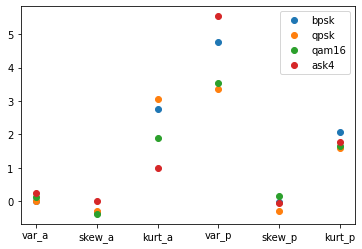

In [5]:
plt.plot(calculate_statistics(bpsk_symbols), 'o')
plt.plot(calculate_statistics(qpsk_symbols), 'o')
plt.plot(calculate_statistics(qam_symbols), 'o')
plt.plot(calculate_statistics(ask4_symbols), 'o')
plt.xticks([0,1,2,3,4,5], ['var_a', 'skew_a', 'kurt_a', 'var_p', 'skew_p', 'kurt_p'])
plt.legend(('bpsk', 'qpsk', 'qam16', 'ask4'))

Based on a glance of these statistics, we can see that the kurtosis of our instantaneous amplitude and variance of the instantaneous phase of these signals can be good indicators to separate the modulation schemes. For example, we could use the phase variance to separate BPSK/4-ASK and QPSK/16-QAM into 2 subgroups. Then use the kurtosis of the amplitude to further discern between BPSK vs 4-ASK and QPSK vs 16-QAM.

Note that this is a very simplified example, and there are a variety of other features one could take advantage of, such as ones based on instantaenous frequency or even spectral fft-based features!

## 1.3 Decision Tree Classifier <a class="anchor" id="dt"></a>

Now that we have identified the main statistical features we can use to tell our signals apart, we can implement a decision tree model, which is essentially a number of threshold and branches defined by if statements.

In [6]:
def dt_classifier(x):
    _, _, a_kurt, p_var, _, _ = calculate_statistics(x)
    
    if p_var > 4:#3.6:
        if a_kurt > 2:
            return 0 # predict BPSK
        else:
            return 3 # predict 4-ASK
    elif a_kurt > 2.5:
        return 1 # predict QPSK
    else:
        return 2 # predict 16-QAM

To make life a bit easier, we can make a class dictionary to easy convert between predicted numbers and names of our schemes.

In [7]:
classes = {0: 'BPSK', 1:'QPSK', 2:'16-QAM', 3:'4-ASK'}

Do a sanity check to make sure that it makes correct predictions for our example waveforms.

In [8]:
print(classes[dt_classifier(bpsk_symbols)])
print(classes[dt_classifier(qpsk_symbols)])
print(classes[dt_classifier(qam_symbols)])
print(classes[dt_classifier(ask4_symbols)])

BPSK
QPSK
16-QAM
4-ASK


**Decision Tree  Accuracy Evaluation**

Now that we have a model, it would be a good idea to find out how robust it is for different channel conditions. Here we loop over a range of SNR values, generate 100 modulated waveforms per modulation scheme and see how many of our predictions were correct.

In [9]:
# Set test parameters
snrs = np.arange(0,25)
num_examples = 500 # number of frames per modulation scheme
num_symbols = 256 # symbols per frame

# Instantiate empty lists where accuracy results will be kept for plotting
bpsk_results, qpsk_results, qam_results, ask4_results = [], [], [], []

for i in range(len(snrs)):
    snr = snrs[i] # current SNR
    
    # Generate all waveforms
    bpsk_data = np.array([generate_bpsk(num_symbols,snr) for i in range(num_examples)])
    qpsk_data = np.array([generate_qpsk(num_symbols,snr) for i in range(num_examples)])
    qam16_data = np.array([generate_qam(num_symbols,snr) for i in range(num_examples)])
    ask4_data = np.array([generate_ask4(num_symbols,snr) for i in range(num_examples)])
    
    # Compute accuracies for each modulation scheme
    bpsk_acc = np.mean([dt_classifier(x)==0 for x in bpsk_data])*100
    qpsk_acc = np.mean([dt_classifier(x)==1 for x in qpsk_data])*100
    qam_acc = np.mean([dt_classifier(x)==2 for x in qam16_data])*100
    ask4_acc = np.mean([dt_classifier(x)==3 for x in ask4_data])*100
    
    # Save results for later plotting
    bpsk_results.append(bpsk_acc)
    qpsk_results.append(qpsk_acc)
    qam_results.append(qam_acc)
    ask4_results.append(ask4_acc)
    
    print('For SNR={}dB, BPSK: {:.2f}%, QPSK: {:.2f}%, 16-QAM: {:.2f}%, 4-ASK: {:.2f}%'.format(snr, bpsk_acc, qpsk_acc, qam_acc, ask4_acc))

For SNR=0dB, BPSK: 5.80%, QPSK: 88.80%, 16-QAM: 14.80%, 4-ASK: 0.00%
For SNR=1dB, BPSK: 10.60%, QPSK: 83.80%, 16-QAM: 12.40%, 4-ASK: 0.00%
For SNR=2dB, BPSK: 22.60%, QPSK: 86.00%, 16-QAM: 20.80%, 4-ASK: 0.00%
For SNR=3dB, BPSK: 36.00%, QPSK: 88.00%, 16-QAM: 24.20%, 4-ASK: 0.00%
For SNR=4dB, BPSK: 44.00%, QPSK: 90.60%, 16-QAM: 28.00%, 4-ASK: 0.20%
For SNR=5dB, BPSK: 55.80%, QPSK: 94.80%, 16-QAM: 33.80%, 4-ASK: 0.80%
For SNR=6dB, BPSK: 69.80%, QPSK: 96.80%, 16-QAM: 39.00%, 4-ASK: 4.20%
For SNR=7dB, BPSK: 78.60%, QPSK: 96.40%, 16-QAM: 39.80%, 4-ASK: 20.20%
For SNR=8dB, BPSK: 86.80%, QPSK: 97.00%, 16-QAM: 48.40%, 4-ASK: 50.80%
For SNR=9dB, BPSK: 89.20%, QPSK: 98.20%, 16-QAM: 55.40%, 4-ASK: 70.40%
For SNR=10dB, BPSK: 92.80%, QPSK: 97.00%, 16-QAM: 60.80%, 4-ASK: 80.80%
For SNR=11dB, BPSK: 95.00%, QPSK: 97.40%, 16-QAM: 68.00%, 4-ASK: 81.20%
For SNR=12dB, BPSK: 97.20%, QPSK: 97.40%, 16-QAM: 71.80%, 4-ASK: 88.20%
For SNR=13dB, BPSK: 98.00%, QPSK: 97.20%, 16-QAM: 80.20%, 4-ASK: 90.80%
For SNR=14

We can also plot our results for a succinct overview.

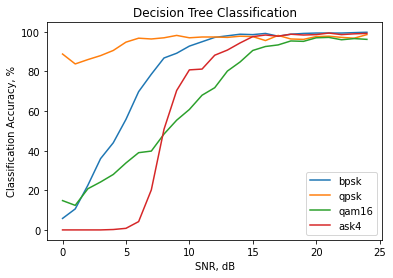

In [10]:
plt.plot(snrs, bpsk_results)
plt.plot(snrs, qpsk_results)
plt.plot(snrs, qam_results)
plt.plot(snrs, ask4_results)
plt.legend(('bpsk', 'qpsk', 'qam16', 'ask4'))
plt.ylabel('Classification Accuracy, %')
plt.xlabel('SNR, dB')
plt.title('Decision Tree Classification')
plt.show()

You can tell from the graph that the model performs extremely well for QPSK, but not quite as well for 16-QAM. We can get further insight on the performance of a classifier by plotting a confusion matrix.

## 1.4 Confusion Matrix <a class="anchor" id="confusion"></a>

Confusion matrices are used very often when evaluating classifiers. Essentially it is a table where we plot the known labels (desired outputs of our classifier) on one axis and predicted labels on the other axis. An ideal classifier will produce a perfect diagonal, however realistic classifier will often misclassify one class as another, seeing exactly which classes get incorrectly misclassified can give us insight into which parts of our model to tune or correct.

We will first generate some test data, at SNR = 15dB.

In [18]:
snr = 15
num_symbols = 256 # number of symbols per frame
num_examples = 100 # number of frames

bpsk_test = np.array([generate_bpsk(num_symbols,snr) for i in range(num_examples)])
qpsk_test = np.array([generate_qpsk(num_symbols,snr) for i in range(num_examples)])
qam16_test = np.array([generate_qam(num_symbols,snr) for i in range(num_examples)])
ask4_test = np.array([generate_ask4(num_symbols,snr) for i in range(num_examples)])

Here we defined a one-hot encoding function, which converts an integer label to a one-hot vector, such as 0 (out of 4) -> [0 0 1 0], 1 -> [0 1 0 0], etc. Some multi-class classifiers require our labels to be one-hot encoded (e.g. neural networks will often be fed one-hot encoded labels during training). Right now we will be using it to more easily construct a confusion matrix.

In [19]:
def to_onehot(labels, num_classes):
    num_labels = len(labels)
    labels_onehot = np.zeros((num_labels, num_classes))
    labels_onehot[np.arange(num_labels),labels] = 1
    
    return labels_onehot

In [20]:
to_onehot([2], num_classes=4)

array([[0., 0., 1., 0.]])

To get our label back from the one-hot encoding we just need to find the argmax of the vector.

In [21]:
np.argmax(to_onehot([2], num_classes=4))

2

Make predictions on our test data.

In [22]:
bpsk_predictions = [dt_classifier(x) for x in bpsk_test]
bpsk_labels = to_onehot(bpsk_predictions, len(classes))

qpsk_predictions = [dt_classifier(x) for x in qpsk_test]
qpsk_labels = to_onehot(qpsk_predictions, len(classes))

qam_predictions = [dt_classifier(x) for x in qam16_test]
qam_labels = to_onehot(qam_predictions, len(classes))

ask4_predictions = [dt_classifier(x) for x in ask4_test]
ask4_labels = to_onehot(ask4_predictions, len(classes))

# double check the expected shape
bpsk_labels.shape

(100, 4)

Note that our labels that the dimensions of our labels are now 500x4, in order to construct the cm we want to condense each one to 1x4 and concatenate them to make up a 4x4 matrix. We can do that by using the numpy sum function, and sum every column, by passing the axis=0 argument.

In [23]:
cm = np.vstack((np.sum(bpsk_labels,axis=0), np.sum(qpsk_labels,axis=0), np.sum(qam_labels,axis=0), np.sum(ask4_labels,axis=0)))

Now we can plot the confusion matrix.

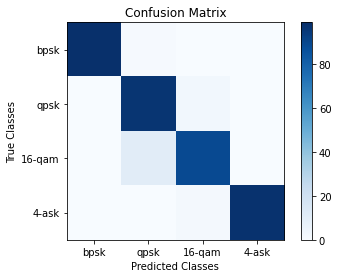

In [24]:
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1,2,3], ['bpsk', 'qpsk', '16-qam', '4-ask'])
plt.yticks([0,1,2,3], ['bpsk', 'qpsk', '16-qam', '4-ask'])
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.colorbar()

Based on our confusion matrix we can see that many 16-QAM instances get falsely misclassified as QPSK, which indicates a bias towards QPSK predictions. Having this insight we could go back to our statistical features, introduce new features to better recognize 16-QAM specifically or tweak the values we use for QPSK and 16-QAM classification.

## 1.5 Conclusion <a class="anchor" id="conclusion"></a>

We learned how to create our very own modulation classifier, based on decision tree rules. However, we only used a small amount of the features available to us and the result could definitely be improved. What if we don't want to tweak threshold values manually, and would rather have it done automatically by the computer? Well, this is where machine learning can come in handy.

[Next Notebook ➡️](02_machine_learning.ipynb)

----
----